In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0QV7J2/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0QV7J2/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
for i in dataset['train'].take(1):
    print(i.keys())
    print(np.unique(i['segmentation_mask']))
    break

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])
[1 2 3]


In [ ]:
shape = (128, 128)
batch_size = 64

def load_ds(sample):
    image = tf.image.resize(sample['image'], shape, method = 'nearest')
    mask  = tf.image.resize(sample['segmentation_mask'], shape, method = 'nearest')

    def preprocess_mask(y):
        stack_list = []
        for c in range(3):
            mask = tf.equal(tf.cast(y[:,:, 0], tf.int32), tf.constant(c + 1))
            stack_list.append(tf.cast(mask, dtype=tf.int32))
        return tf.stack(stack_list, axis=2)
    
    return tf.cast(image, tf.float32)/255.0, preprocess_mask(mask)

def prepare_ds(ds, train = True):
    ds = ds.map(load_ds)
    if train:
        ds = ds.shuffle(1024, reshuffle_each_iteration=True)
    return ds.repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE).batch(batch_size)

train = prepare_ds(dataset['train'])
test  = prepare_ds(dataset['test'], False)

In [ ]:
for i, j in train.take(1):
    print(np.max(i))
    print(np.sum(j), 64*128*128)
    break

1.0
1048576 1048576


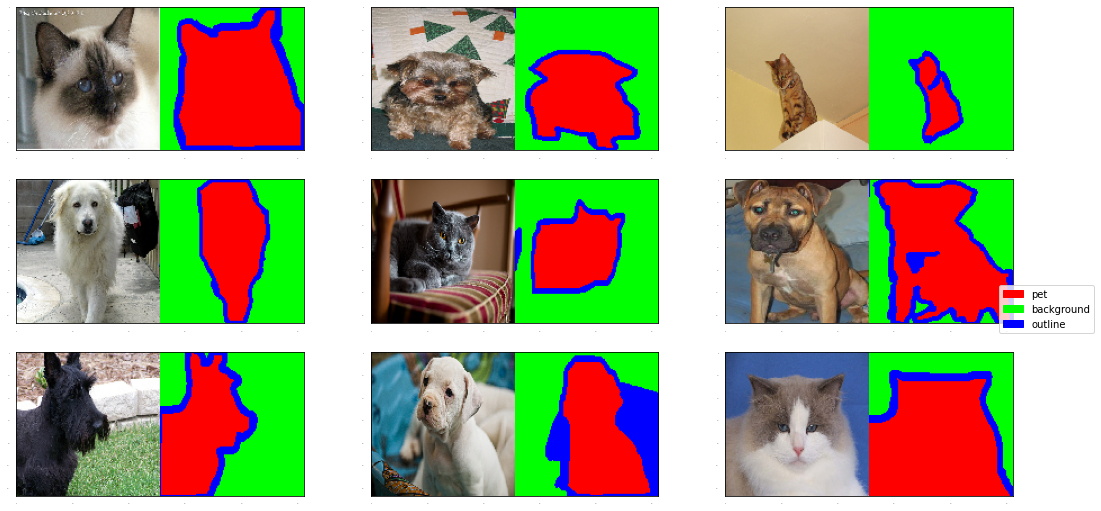

In [ ]:
colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
class_names = ['pet', 'background', 'outline']

def show_image_mask(image, masks):
    choice = np.random.randint(0, image.shape[0], 9)
    
    fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize = (18, 9))
    
    for i in range(9):
        im   = np.concatenate([np.uint16(image[choice[i]]*255.0), masks[choice[i]]*255], axis = 1)
        ax[int(i//3), int(i%3)].imshow(im)
    import matplotlib.patches as mpatches
    handles = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
    plt.legend(handles=handles, bbox_to_anchor=(1.3, 1.5))

show_image_mask(i, j)

In [ ]:
def encoder(x):
    def encoder_block(x, filters, name, kernel_size = (3, 3), dropout = 0.3):
        c1 = tf.keras.layers.Conv2D(kernel_size = kernel_size, filters = filters, padding = 'same', activation = 'relu', name = f'{name}_conv1')(x)
        c2 = tf.keras.layers.Conv2D(kernel_size = kernel_size, filters = filters, padding = 'same', activation = 'relu', name = f'{name}_conv2')(c1)
        p = tf.keras.layers.MaxPool2D((2, 2), strides = (2, 2), name = f'{name}_pool3')(c2)
        d = tf.keras.layers.Dropout(dropout, name = f'{name}_dropout4')(p)
        return c2, d
    
    conv_outputs = []
    for i in range(6, 10):
        c, x = encoder_block(x, 2**i, name = f'enc_block{i-5}')
        conv_outputs.append(c)
    
    return conv_outputs, x

def decoder(x, conv_outputs):
    def decoder_block(x, enc, filters, name, kernel_size = (3, 3)):

        ct1 = tf.keras.layers.Conv2DTranspose(filters, kernel_size=(3, 3),  strides=(2, 2), padding = 'same')(x)
        con = tf.keras.layers.Concatenate(axis = -1)([enc, ct1])
        c1 = tf.keras.layers.Conv2D(filters, kernel_size, padding = 'same', activation = 'relu', name = f'{name}_conv1')(con)
        c2 = tf.keras.layers.Conv2D(filters, kernel_size, padding = 'same', activation = 'relu', name = f'{name}_conv2')(c1)
        return c2
    
    for i in range(3, -1, -1):
        enc = conv_outputs[i]
        x = decoder_block(x, enc, 2**(i + 6), name = f'dec_block{i+1}')
    
    return x

inputs = tf.keras.layers.Input(shape=(128,128,3,))
encoder, out = encoder(inputs)
bottleneck = tf.keras.layers.Conv2D(1024, (3, 3), padding = 'same', activation = 'relu', name = f'bottleneck_conv1')(out)
bottleneck = tf.keras.layers.Conv2D(1024, (3, 3), padding = 'same', activation = 'relu', name = f'bottleneck_conv2')(bottleneck)

decoder = decoder(bottleneck, encoder)
outputs = tf.keras.layers.Conv2D(3, (1, 1), padding = 'same', activation = 'softmax', name = f'output_conv')(decoder)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 enc_block1_conv1 (Conv2D)      (None, 128, 128, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 enc_block1_conv2 (Conv2D)      (None, 128, 128, 64  36928       ['enc_block1_conv1[0][0]']       
                                )                                                           

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 10
val_steps   = info.splits['test'].num_examples //batch_size
train_steps = info.splits['train'].num_examples//batch_size

print(train, '\n',test)


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.int32, name=None))> 
 <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.int32, name=None))>


In [ ]:
history = model.fit(train, epochs=epochs,
                          steps_per_epoch=train_steps,
                          validation_steps=val_steps,
                          validation_data=test)


Epoch 1/10
57/57 [==============================] - 75s 1s/step - loss: 0.9335 - accuracy: 0.5805 - val_loss: 0.8395 - val_accuracy: 0.5772
Epoch 2/10
57/57 [==============================] - 68s 1s/step - loss: 0.7707 - accuracy: 0.6572 - val_loss: 0.7188 - val_accuracy: 0.6980
Epoch 3/10
57/57 [==============================] - 68s 1s/step - loss: 0.6962 - accuracy: 0.7127 - val_loss: 0.6859 - val_accuracy: 0.7161
Epoch 4/10
57/57 [==============================] - 68s 1s/step - loss: 0.6422 - accuracy: 0.7376 - val_loss: 0.6092 - val_accuracy: 0.7534
Epoch 5/10
57/57 [==============================] - 68s 1s/step - loss: 0.6079 - accuracy: 0.7544 - val_loss: 0.5582 - val_accuracy: 0.7790
Epoch 6/10
57/57 [==============================] - 68s 1s/step - loss: 0.5539 - accuracy: 0.7810 - val_loss: 0.5188 - val_accuracy: 0.7957
Epoch 7/10
57/57 [==============================] - 68s 1s/step - loss: 0.5096 - accuracy: 0.8009 - val_loss: 0.4689 - val_accuracy: 0.8174
Epoch 8/10
57/57 [==

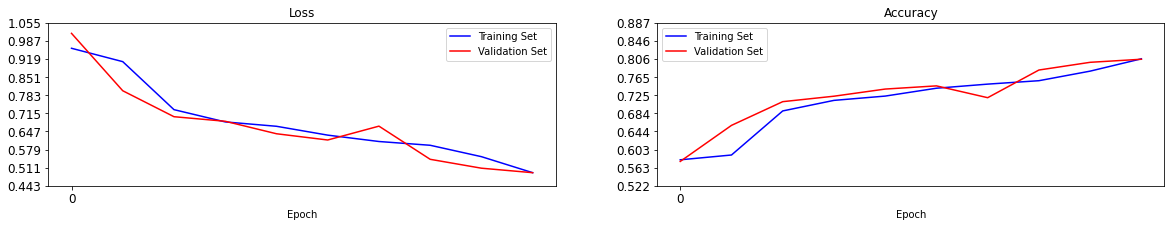

In [ ]:
history = model_history
fig, ax = plt.subplots(ncols = 2, figsize = (20, 3))
plots = [['loss', 'val_loss'], ['accuracy', 'val_accuracy']]
epochs = np.arange(len(history.history['loss']))

for i in [0, 1]:
  ax[i].plot(epochs, history.history[plots[i][0]], color = 'b', label = 'Training Set')
  ax[i].plot(epochs, history.history[plots[i][1]], color = 'r', label = 'Validation Set')
  ax[i].set_title(plots[i][0].capitalize())

  ax[i].tick_params(bottom=True, left=True)
  ax[i].set_xticks(epochs[::10])
  ax[i].set_xticklabels(epochs[::10], fontdict = {'fontsize':12,})

  ax[i].tick_params(bottom=True, left=True)
  ax[i].set_yticks(np.linspace( min( history.history[plots[i][0]])*0.9,  max(history.history[plots[i][0]])*1.1, 10 ))
  ax[i].set_yticklabels([str(j)[:5] for j in np.linspace( min( history.history[plots[i][0]])*0.9,  max(history.history[plots[i][0]])*1.1, 10 )], fontdict = {'fontsize':12,})
  ax[i].set_xlabel('Epoch')
  ax[i].legend()

In [ ]:
for im, mask in test.take(1):
  break
prediction = model.predict(im)
print(prediction.shape)

2/2 [==============================] - 0s 190ms/step
(64, 128, 128, 3)


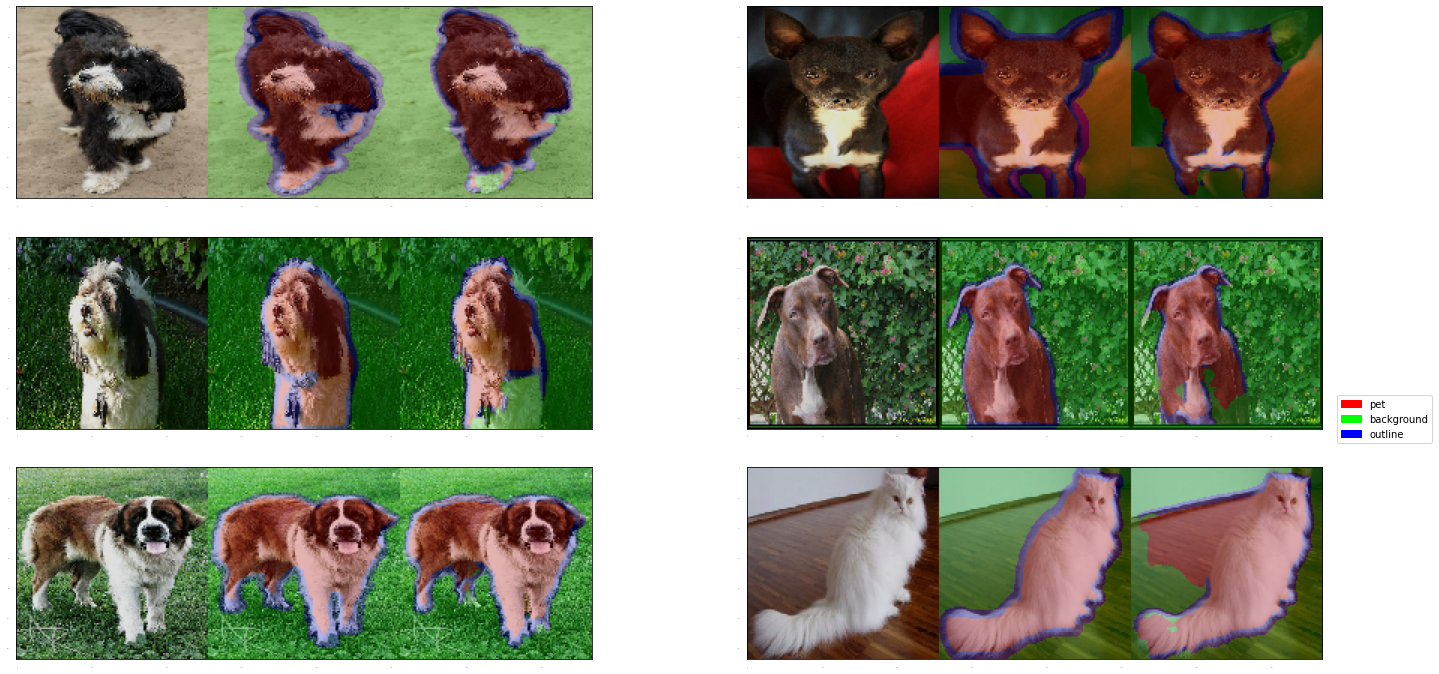

In [ ]:
def show_image_predictions(image, masks, predictions):
    choice = np.random.randint(0, image.shape[0], 6)
    fig, ax = plt.subplots(ncols = 2, nrows = 3, figsize = (24, 12))
    
    for i in range(6):
        pred = predictions[choice[i]]
        pmax = np.max(pred, axis = 2, keepdims = True)
        pout = np.isclose(pred, pmax).astype(int)
        pred = pout*255

        mask = masks[choice[i]] * 255
        im   = np.uint16(image[choice[i]]*225)
        mask = 8*im//10 + 2*mask//10
        pred = 8*im//10 + 2*pred//10

        im   = np.uint16(np.concatenate([im, mask], axis = 1))
        im   = np.concatenate([im, pred], axis = 1)
        ax[int(i//2), int(i%2)].imshow(im)

    import matplotlib.patches as mpatches
    handles = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
    plt.legend(handles=handles, bbox_to_anchor=(1.2, 1.4))
    # ax[1].legend(, class_names)
#must convert outputs to int. accross dimension 4 set the highest value to 1 and rest to 0
show_image_predictions(im, mask, tf.convert_to_tensor(prediction))

In [ ]:
mask_i = np.argmax(mask, axis = 3)
prediction_i = np.argmax(prediction, axis = 3)

iou = []
for i in range(3):
  overlap = np.sum((mask_i == i) * (prediction_i == i))
  in_pred = (prediction_i == i).sum()
  in_mask = (mask_i == i).sum()
  iou.append(overlap/(in_pred + in_mask - overlap))

for i in np.argsort(iou)[::-1]:
  print("For class {:^15} the IoU is \t {:0.04f}".format(class_names[i], iou[i]))


For class   background    the IoU is 	 0.8224
For class       pet       the IoU is 	 0.7019
For class     outline     the IoU is 	 0.3689
